# Experiments for detection and manipulation.

After training an optimized autencoder over the ssh server, we began experimenting with different methods of changing the coor fo the eye, and manipulating the latent vectors or embeddings of the images.


NOTE:
This code was partially developed using ChatGPT, and Claude 3.5 Sonnet

In [1]:

# USE THOS
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Important imports

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model, load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
from scipy import interpolate
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import seaborn as sns

# USE THOS


Install commands

The line where the decoder saved state is loaded (decoder = load_model(filepath, custom_objects={'Conv2DTranspose': tf.keras.layers.Conv2DTranspose})) will not work unless the tensorflow version is 2.11.0.

Once ran, you will need to restart the session. You will not need to run the cell to install tensorflow v2.11.0 again. You may need to install the other libraries.

In [3]:
!pip install tensorflow==2.11.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 28.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: keras
    Found existing installation: kera

In [3]:
!pip install Pillow

In [4]:
!pip install colormath

  Using cached colormath-3.0.0-py3-none-any.whl


In [5]:
!pip install gradio

  Using cached gradio-5.8.0-py3-none-any.whl.metadata (16 kB)
  Using cached aiofiles-23.2.1-py3-none-any.whl.metadata (9.7 kB)
  Using cached fastapi-0.115.6-py3-none-any.whl.metadata (27 kB)
  Using cached ffmpy-0.4.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached gradio_client-1.5.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached MarkupSafe-2.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached python_multipart-0.0.19-py3-none-any.whl.metadata (1.8 kB)
  Using cached ruff-0.8.2-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached safehttpx-0.1.6-py3-none-any.whl.metadata (4.2 kB)
  Using cached semantic_version-2.10.0-py2.py3-none-any.whl.metadata (9.7 kB)
  Using cached starlette-0.41.3-py3-none-any.whl.metadata (6.0 kB)
  Using cached tomlkit-0.13.2-py3-none-any.whl.metadata (2.7 kB)
  Using cached uvicorn-0.32.1-py3-none-any.whl.met

In [6]:
!pip install imageio

In [7]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.4 MB/s eta 0:00:00


# Loading Encoder/Data

This loads the saved state of the first half of the autencoder, which is the encoder. Over the remote server, the UBIRIS images are passed into the encoder, and the result is data and vectors representing each image.

In [57]:
# USE THOS

IMG_SIZE = 128
LATENT_DIM = 64


image1 = cv2.imread('/content/drive/MyDrive/ML final project/our_eyes/IMG_1636.JPG')
image2 = cv2.imread('/content/drive/MyDrive/ML final project/our_eyes/IMG_1642.JPG')
image3 = cv2.imread('/content/drive/MyDrive/ML final project/our_eyes/IMG_1656.JPG')


"""
# Load the saved latent vectors and encoder model (FULL)
filepath = r'/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_model1.5.h5'
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors1.5.npy')
image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data1.5.npy')
encoder = load_model(filepath)
#encoder = tf.keras.layers.TFSMLayer('encoder_model', call_endpoint='serving_default')
#image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_filtered/image_data8.npy')
"""

"\n# Load the saved latent vectors and encoder model (FULL)\nfilepath = r'/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_model1.5.h5'\nlatent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/latent_vectors1.5.npy')\nimage_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/image_data1.5.npy')\nencoder = load_model(filepath)\n#encoder = tf.keras.layers.TFSMLayer('encoder_model', call_endpoint='serving_default')\n#image_data = np.load('/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_filtered/image_data8.npy')\n"

In [58]:
# Paths
TEST_IMAGE_FOLDER = '/content/drive/MyDrive/ML final project/datasets/testData'
TEST_LABELS_CSV = '/content/drive/MyDrive/ML final project/datasets/test_labels.csv'
filepath_encoder = '/content/drive/MyDrive/ML final project/Trained_models/encoder/encoder_model_f'
filepath_decoder = '/content/drive/MyDrive/ML final project/Trained_models/decoder/decoder_model_f'
filepath_autoencoder = '/content/drive/MyDrive/ML final project/Trained_models/autoencoder_model_f'

# Load the models (note: no need for custom_objects here)
encoder = tf.keras.models.load_model(filepath_encoder)
decoder = tf.keras.models.load_model(filepath_decoder)
autoencoder = tf.keras.models.load_model(filepath_autoencoder)



In [59]:
# Load the stored latent vectors
latent_vectors = np.load('/content/drive/MyDrive/ML final project/Trained_models/latent_vectors_f.npy')

# View a single latent vector (e.g., the first one)
single_vector = latent_vectors[0]  # Gets the first vector
print("Single Latent Vector:")
print(single_vector)

# If you want to see its shape
print("\nVector shape:", single_vector.shape)

# If you want to view a specific index
index = 5  # Change this to view different vectors
specific_vector = latent_vectors[index]
print(f"\nLatent vector at index {index}:")
print(specific_vector)

# Optional: If you want to see it alongside its corresponding image label
# Load the vector mapping file if you saved it
vector_mapping = pd.read_csv('/content/drive/MyDrive/ML final project/Trained_models/vector_mapping_f.csv')
print(f"\nCorresponding image filename: {vector_mapping['filename'][index]}")
print(f"Eye color label: {vector_mapping['label'][index]}")

Single Latent Vector:
[  11.395286   -38.768093   -11.278207     6.2685933  -23.96136
   -7.3763313   30.21694     26.891083   -26.011734    14.868805
  -12.830528     6.492675   -59.574833    70.231316    -7.9210753
   25.823278   -23.801788  -110.238556   -38.10071    -12.762578
   21.416515   -74.72646      8.456845    -6.40265    -18.067213
  -44.89838     19.347084    45.043842    21.722351   -58.143585
    5.6315937    7.2973647  -13.594831    17.516306   -11.60289
    1.4304689  -18.256247   -11.018762   -12.5074215  -15.6609125
  -19.383093   -56.48194    -40.87013    -38.651188   -76.96618
  -13.841428   -78.749054   -36.750988    19.82189     20.061655
   42.092266   -31.267889    -9.538439    21.125305    23.152159
   -4.782459    25.81       -66.70396      7.773647    32.75838
  -14.251935     7.18254     -4.093995   -47.301254 ]

Vector shape: (64,)

Latent vector at index 5:
[   6.2394223     2.157854    -10.98816      13.759844    -37.795425
  -18.095015     14.944678   

# TESTING
function for preprocessing image1 and image2

In [11]:

from PIL import Image
def preprocess_image(image):
    """Preprocesses an image for the encoder using PIL for better quality."""
    # Check if image is None
    if image is None:
        raise ValueError("Input image is None")

    # Convert BGR to RGB (OpenCV loads in BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert NumPy array to PIL Image
    try:
        image_pil = Image.fromarray(image)
    except Exception as e:
        print(f"Error converting to PIL Image: {e}")
        print(f"Image shape: {image.shape}, dtype: {image.dtype}")
        raise

    # Resize using PIL with high-quality interpolation
    image_resized = image_pil.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

    # Convert back to NumPy array and normalize
    image_resized = np.array(image_resized)

    # Ensure float32 type and proper normalization
    image_normalized = image_resized.astype(np.float32) / 255.0

    # Debug prints
    print(f"Preprocessed image shape: {image_normalized.shape}")
    print(f"Value range: [{image_normalized.min():.3f}, {image_normalized.max():.3f}]")

    return image_normalized

# When loading individual images:
def load_and_preprocess_single_image(image_path):
    """Load and preprocess a single image."""
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not load image from {image_path}")

    # Preprocess
    preprocessed = preprocess_image(image)
    return preprocessed

image1_preprocessed = preprocess_image(image1)
image2_preprocessed = preprocess_image(image2)
image3_preprocessed = preprocess_image(image3)

Preprocessed image shape: (128, 128, 3)
Value range: [0.024, 0.976]
Preprocessed image shape: (128, 128, 3)
Value range: [0.000, 0.984]
Preprocessed image shape: (128, 128, 3)
Value range: [0.016, 0.953]


Function for preprocessing the larger set of test data. (combine with above function?)

In [12]:
def load_test_data():
    """Load and preprocess test dataset"""
    # Read and sort the CSV file
    labels_df = pd.read_csv(TEST_LABELS_CSV)
    labels_df['C'] = labels_df['filename'].str.extract(r'C(\d+)')[0].astype(int)
    labels_df['S'] = labels_df['filename'].str.extract(r'S(\d+)')[0].astype(int)
    labels_df['I'] = labels_df['filename'].str.extract(r'I(\d+)')[0].astype(int)
    labels_df = labels_df.sort_values(['C', 'S', 'I'])

    # Load and preprocess images
    image_data = []
    for filename in labels_df['filename']:
        image_path = os.path.join(TEST_IMAGE_FOLDER, filename)
        if os.path.exists(image_path):
            img = Image.open(image_path)
            img = img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)
            img_array = np.array(img)
            img_array = img_array.astype("float32") / 255.0
            image_data.append(img_array)

    image_data = np.array(image_data)
    return image_data, labels_df

def generate_latent_vectors(encoder, image_data):
    """Generate latent vectors for the test dataset"""
    return encoder.predict(image_data)

In [13]:
def preprocess_images(image_path):
    """Preprocesses an image for the encoder using PIL for better quality."""
    input_shape = encoder.input_shape[1:]  # Get input shape from the encoder

    # Open and resize image using PIL with high-quality interpolation
    image_pil = Image.open(image_path)
    image_resized = image_pil.resize((input_shape[1], input_shape[0]), Image.LANCZOS)

    # Convert back to NumPy array and normalize
    image_resized = np.array(image_resized)
    image_normalized = image_resized / 255.0
    image_preprocessed = image_normalized.astype(np.float32)
    return image_preprocessed

def generate_test_data(folder_path):
    """Generates image_data and latent_vectors from a folder of images."""
    image_data = []
    latent_vectors = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.tiff'):  # Adjust extensions as needed
            image_path = os.path.join(folder_path, filename)

            # Load the image first using cv2
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to load image: {image_path}")
                continue

            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


            # Preprocess the image
            preprocessed_image = preprocess_image(image)

            # Add preprocessed image to image_data
            image_data.append(preprocessed_image)

            # Get latent vector using the encoder
            latent_vector = encoder.predict(np.expand_dims(preprocessed_image, axis=0))
            latent_vectors.append(latent_vector.flatten())  # Flatten to 1D

    return np.array(image_data), np.array(latent_vectors)


# This is used to normalize the embeddings, which he;ps with the decoding process.

In [14]:
# USE THOS

import numpy as np

# Normalize the latent vector to range 0 to 1 for better interpretability
def scale_latent_vector(test_latent_vectors):
    min_val = np.min(test_latent_vectors)
    max_val = np.max(test_latent_vectors)

    # Normalize to [0, 1] range
    scaled_latent_vector = (test_latent_vectors - min_val) / (max_val - min_val)
    return scaled_latent_vector


In [15]:
# WORKING
# USE THOS

# Function to reconstruct images from latent vectors
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    # Display original vs reconstructed images
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        # Reconstructed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')

    plt.tight_layout()
    plt.show()

# Function to interpolate between two images
def interpolate_images(decoder, latent_vector1, latent_vector2, num_steps=10):
    """Interpolate between two latent vectors and generate images"""
    alphas = np.linspace(0, 1, num_steps)
    interpolated_vectors = []

    for alpha in alphas:
        interpolated_vector = (1 - alpha) * latent_vector1 + alpha * latent_vector2
        interpolated_vectors.append(interpolated_vector)

    interpolated_vectors = np.array(interpolated_vectors)
    interpolated_images = decoder.predict(interpolated_vectors)

    return interpolated_images

def display_interpolation(interpolated_images, color1=None, color2=None):
    """Display interpolation results"""
    plt.figure(figsize=(15, 3))
    for i in range(len(interpolated_images)):
        plt.subplot(1, len(interpolated_images), i + 1)
        plt.imshow(interpolated_images[i])
        plt.axis('off')
        if i == 0 and color1:
            plt.title(f'{color1}', loc='left')
        elif i == len(interpolated_images)-1 and color2:
            plt.title(f'{color2}', loc='right')
    plt.tight_layout()
    plt.show()

In [ ]:
print(os.path.exists(filepath))

NameError: name 'filepath' is not defined

Functions to interpolate the first image found for each class

In [16]:
# USE THOS

# WORKING
def get_color_examples(labels_df, latent_vectors, color_name, n=1):
    """Get latent vectors for eyes of a specific color"""
    color_indices = labels_df[labels_df['label'] == color_name].index[:n]
    return latent_vectors[color_indices]

def interpolate_color_sequence(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green', 'gray'], steps_between=10):
    """Create a sequence of interpolations between different eye colors"""
    # Get one example for each color
    color_vectors = [get_color_examples(labels_df, latent_vectors, color, 1)[0] for color in colors]

    plt.figure(figsize=(20, 4 * (len(colors)-1)))
    current_plot = 1

    # Interpolate between consecutive colors
    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")

        # Create interpolation
        alphas = np.linspace(0, 1, steps_between)
        interpolated_vectors = []

        for alpha in alphas:
            interpolated_vector = (1 - alpha) * color_vectors[i] + alpha * color_vectors[i+1]
            interpolated_vectors.append(interpolated_vector)

        interpolated_vectors = np.array(interpolated_vectors)
        interpolated_images = decoder.predict(interpolated_vectors)
        interpolated_images = np.clip(interpolated_images, 0, 1)


        # Plot this interpolation sequence
        plt.subplot(len(colors)-1, 1, current_plot)
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

# More Imports, Loading Decoder And Data

In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.cluster import KMeans
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000




# Function to call decoder to reconstruct images from vectors

In [18]:
def reconstruct_images(latent_vectors, num_images=5):
    reconstructed = decoder.predict(latent_vectors[:num_images])
    reconstructed = np.clip(reconstructed, 0, 1)

    plt.figure(figsize=(15, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(test_image_data[i])
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed[i])
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
        # Calculate Mean Squared Error (MSE)
        mse = np.mean(np.square(test_image_data[:num_images] - reconstructed))
        print(f"Reconstruction MSE: {mse}")

    plt.tight_layout()
    plt.show()

# Function to interpolate two random images from different classes

In [19]:
import random
# USE THOS

def randomer_interpolater(decoder, latent_vectors, labels_df, colors=['brown', 'blue', 'hazel', 'green', 'gray'], steps_between=10):
    """Create random interpolations between different eye colors"""
    color_vectors = []
    selected_indices = []

    for color in colors:
        color_indices = labels_df[labels_df['label'] == color].index
        if len(color_indices) > 0:
            random_index = random.choice(color_indices)
            color_vectors.append(latent_vectors[random_index])
            selected_indices.append(random_index)
        else:
            print(f"Warning: No images found for color {color}")
            return

    plt.figure(figsize=(20, 5 * (len(colors)-1)))
    current_plot = 1

    for i in range(len(colors)-1):
        print(f"Interpolating from {colors[i]} to {colors[i+1]}...")
        interpolated_images = interpolate_images(
            decoder,
            color_vectors[i],
            color_vectors[i+1],
            steps_between
        )

        # Display original images and interpolation
        for j in range(steps_between):
            plt.subplot(len(colors)-1, steps_between, (current_plot-1)*steps_between + j + 1)
            plt.imshow(interpolated_images[j])
            plt.axis('off')
            if j == 0:
                plt.title(f'{colors[i]}', loc='left')
            elif j == steps_between-1:
                plt.title(f'{colors[i+1]}', loc='right')

        current_plot += 1

    plt.tight_layout()
    plt.show()

# Function to calculate how accurate the interpolation is.
This is a good idea to show evaluation metrics, but it is not currently working

In [46]:
# USE THOS

# ... existing imports ...


def calculate_reconstruction_metrics(original_images, reconstructed_images):
    """Calculate various reconstruction error metrics"""
    # Mean Squared Error (MSE)
    mse = mean_squared_error(original_images.reshape(len(original_images), -1),
                           reconstructed_images.reshape(len(reconstructed_images), -1))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(original_images - reconstructed_images))

    # Peak Signal-to-Noise Ratio (PSNR)
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'PSNR': psnr
    }

def plot_tsne_visualization(latent_vectors, labels_df, perplexity=30):
    """Create t-SNE visualization of the latent space"""
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Create DataFrame for plotting
    df = pd.DataFrame({
        'x': latent_2d[:, 0],
        'y': latent_2d[:, 1],
        'color': labels_df['label']
    })

    # Plot
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='x', y='y', hue='color', alpha=0.6)
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Eye Color')
    plt.show()



def calculate_interpolation_accuracy(interpolated_images, true_labels, color_mapping):
    predicted_labels = []
    for image in interpolated_images:
        dominant_color = get_dominant_iris_color(image)
        if dominant_color is not None:
            min_dist = float('inf')
            predicted_color = None

            for color_name, color_value in color_mapping.items():
                color1_rgb = sRGBColor(*dominant_color / 255.0)
                color2_rgb = sRGBColor(*np.array(color_value) / 255.0)
                color1_lab = convert_color(color1_rgb, LabColor)
                color2_lab = convert_color(color2_rgb, LabColor)

                delta_e = delta_e_cie2000(color1_lab, color2_lab)

                if delta_e < min_dist:
                    min_dist = delta_e
                    predicted_color = color_name

            predicted_labels.append(predicted_color)
        else:
            predicted_labels.append(None)

    # Filter out None values (cases where iris was not detected)
    valid_indices = [i for i, label in enumerate(predicted_labels) if label is not None]
    predicted_labels = np.array(predicted_labels)[valid_indices]
    true_labels = true_labels[valid_indices]

    # Calculate accuracy
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Interpolation Accuracy: {accuracy}")
    return accuracy


import umap
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_multiple_visualizations(latent_vectors, labels_df):
    # Set up the figure
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))

    # 1. UMAP
    reducer = umap.UMAP(random_state=42)
    umap_embedded = reducer.fit_transform(latent_vectors)

    sns.scatterplot(
        x=umap_embedded[:, 0],
        y=umap_embedded[:, 1],
        hue=labels_df['label'],
        alpha=0.6,
        ax=axes[0,0]
    )
    axes[0,0].set_title('UMAP Visualization')

    # 2. PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)

    sns.scatterplot(
        x=pca_result[:, 0],
        y=pca_result[:, 1],
        hue=labels_df['label'],
        alpha=0.6,
        ax=axes[0,1]
    )
    axes[0,1].set_title(f'PCA Visualization\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}')

    # 3. Distribution of latent dimensions
    # Take first 10 dimensions for visualization

    latent_df = pd.DataFrame(latent_vectors[:, :4],
                           columns=[f'Dim_{i+1}' for i in range(4)])

    sns.boxplot(data=latent_df, ax=axes[1,0])
    axes[1,0].set_title('Distribution of 8 Latent Dimensions')
    axes[1,0].tick_params(axis='x', rotation=45)

    # 4. Correlation matrix of first 10 latent dimensions
    corr_matrix = latent_df.iloc[:, :4].corr()
    sns.heatmap(corr_matrix, ax=axes[1,1], cmap='coolwarm', center=0)
    axes[1,1].set_title('Correlation Matrix of Latent Dimensions')

    plt.tight_layout()
    plt.show()

    # Additional: Class distribution
    plt.figure(figsize=(10, 5))
    sns.countplot(data=labels_df, x='label')
    plt.title('Distribution of Eye Colors in Dataset')
    plt.xticks(rotation=45)
    plt.show()

# Function to plot 20 random images
This function needs some tweaking, but it is great for visualizing the dataset, and ensuring that labels are attached to the appropriate image.

In [21]:
# TESTING
def plot_random_samples(test_data, idx_to_color):
    """Plot 20 random samples from the test data in a 4x5 grid"""
    # Select 20 random indices
    indices = np.random.choice(len(test_data), 20, replace=False)

    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = test_data[idx]

        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img_denorm = image * std + mean

        # Plot
        plt.subplot(4, 5, i + 1)
        plt.imshow(img_denorm.permute(1, 2, 0).clamp(0, 1))
        plt.title(idx_to_color[label.item()], pad=5)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Main function

explaination:
- loads the label csv file. If you use other dataset, change this
- color mapping: This is used for any future plotting, so that points can be colored according to their color class.
- reconstruct images: displays the first five images, then reconstructs them via the decoder.
- interpolating: there are two function calls, and one is commented out. If you want to interpolate from the same images each time you run this main, uncomment the first function call, and comment out the randomer_interpolater function. If you want to see random image interpolation, do the opposite.


In [60]:
    print("Loading test data...")
    test_image_data, test_labels_df = load_test_data()
    print(f"Loaded {len(test_image_data)} test images")
    # Generate latent vectors for test data
    print("Generating latent vectors...")
    test_latent_vectors = generate_latent_vectors(encoder, test_image_data)

Loading test data...
Loaded 2221 test images
Generating latent vectors...
70/70 [==============================] - 8s 115ms/step


Reconstructing sample images...
1/1 [==============================] - 0s 285ms/step
Reconstruction MSE: 0.0024851912166923285
Reconstruction MSE: 0.0024851912166923285
Reconstruction MSE: 0.0024851912166923285
Reconstruction MSE: 0.0024851912166923285
Reconstruction MSE: 0.0024851912166923285


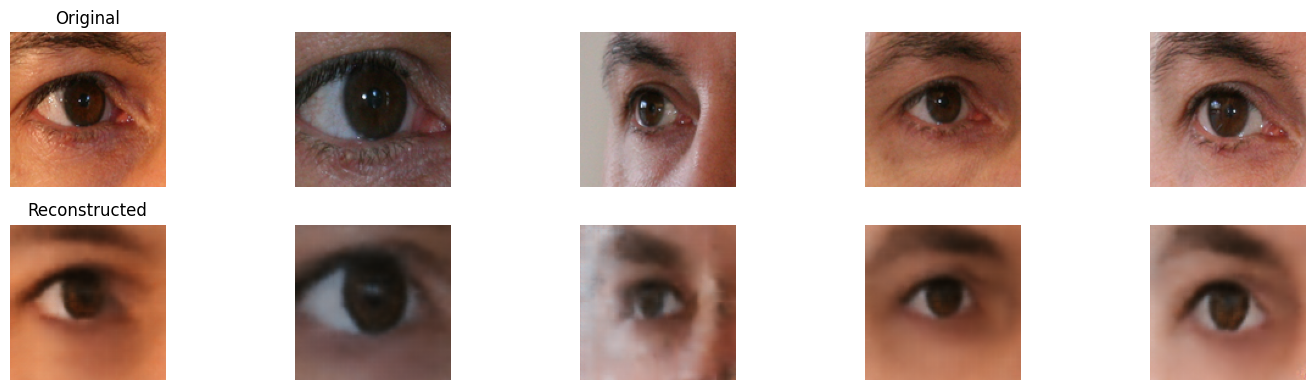


Interpolating between different eye colors...
Interpolating from brown to blue...
1/1 [==============================] - 0s 97ms/step
Interpolating from blue to hazel...
1/1 [==============================] - 0s 85ms/step
Interpolating from hazel to green...
1/1 [==============================] - 0s 81ms/step
Interpolating from green to gray...
1/1 [==============================] - 0s 171ms/step


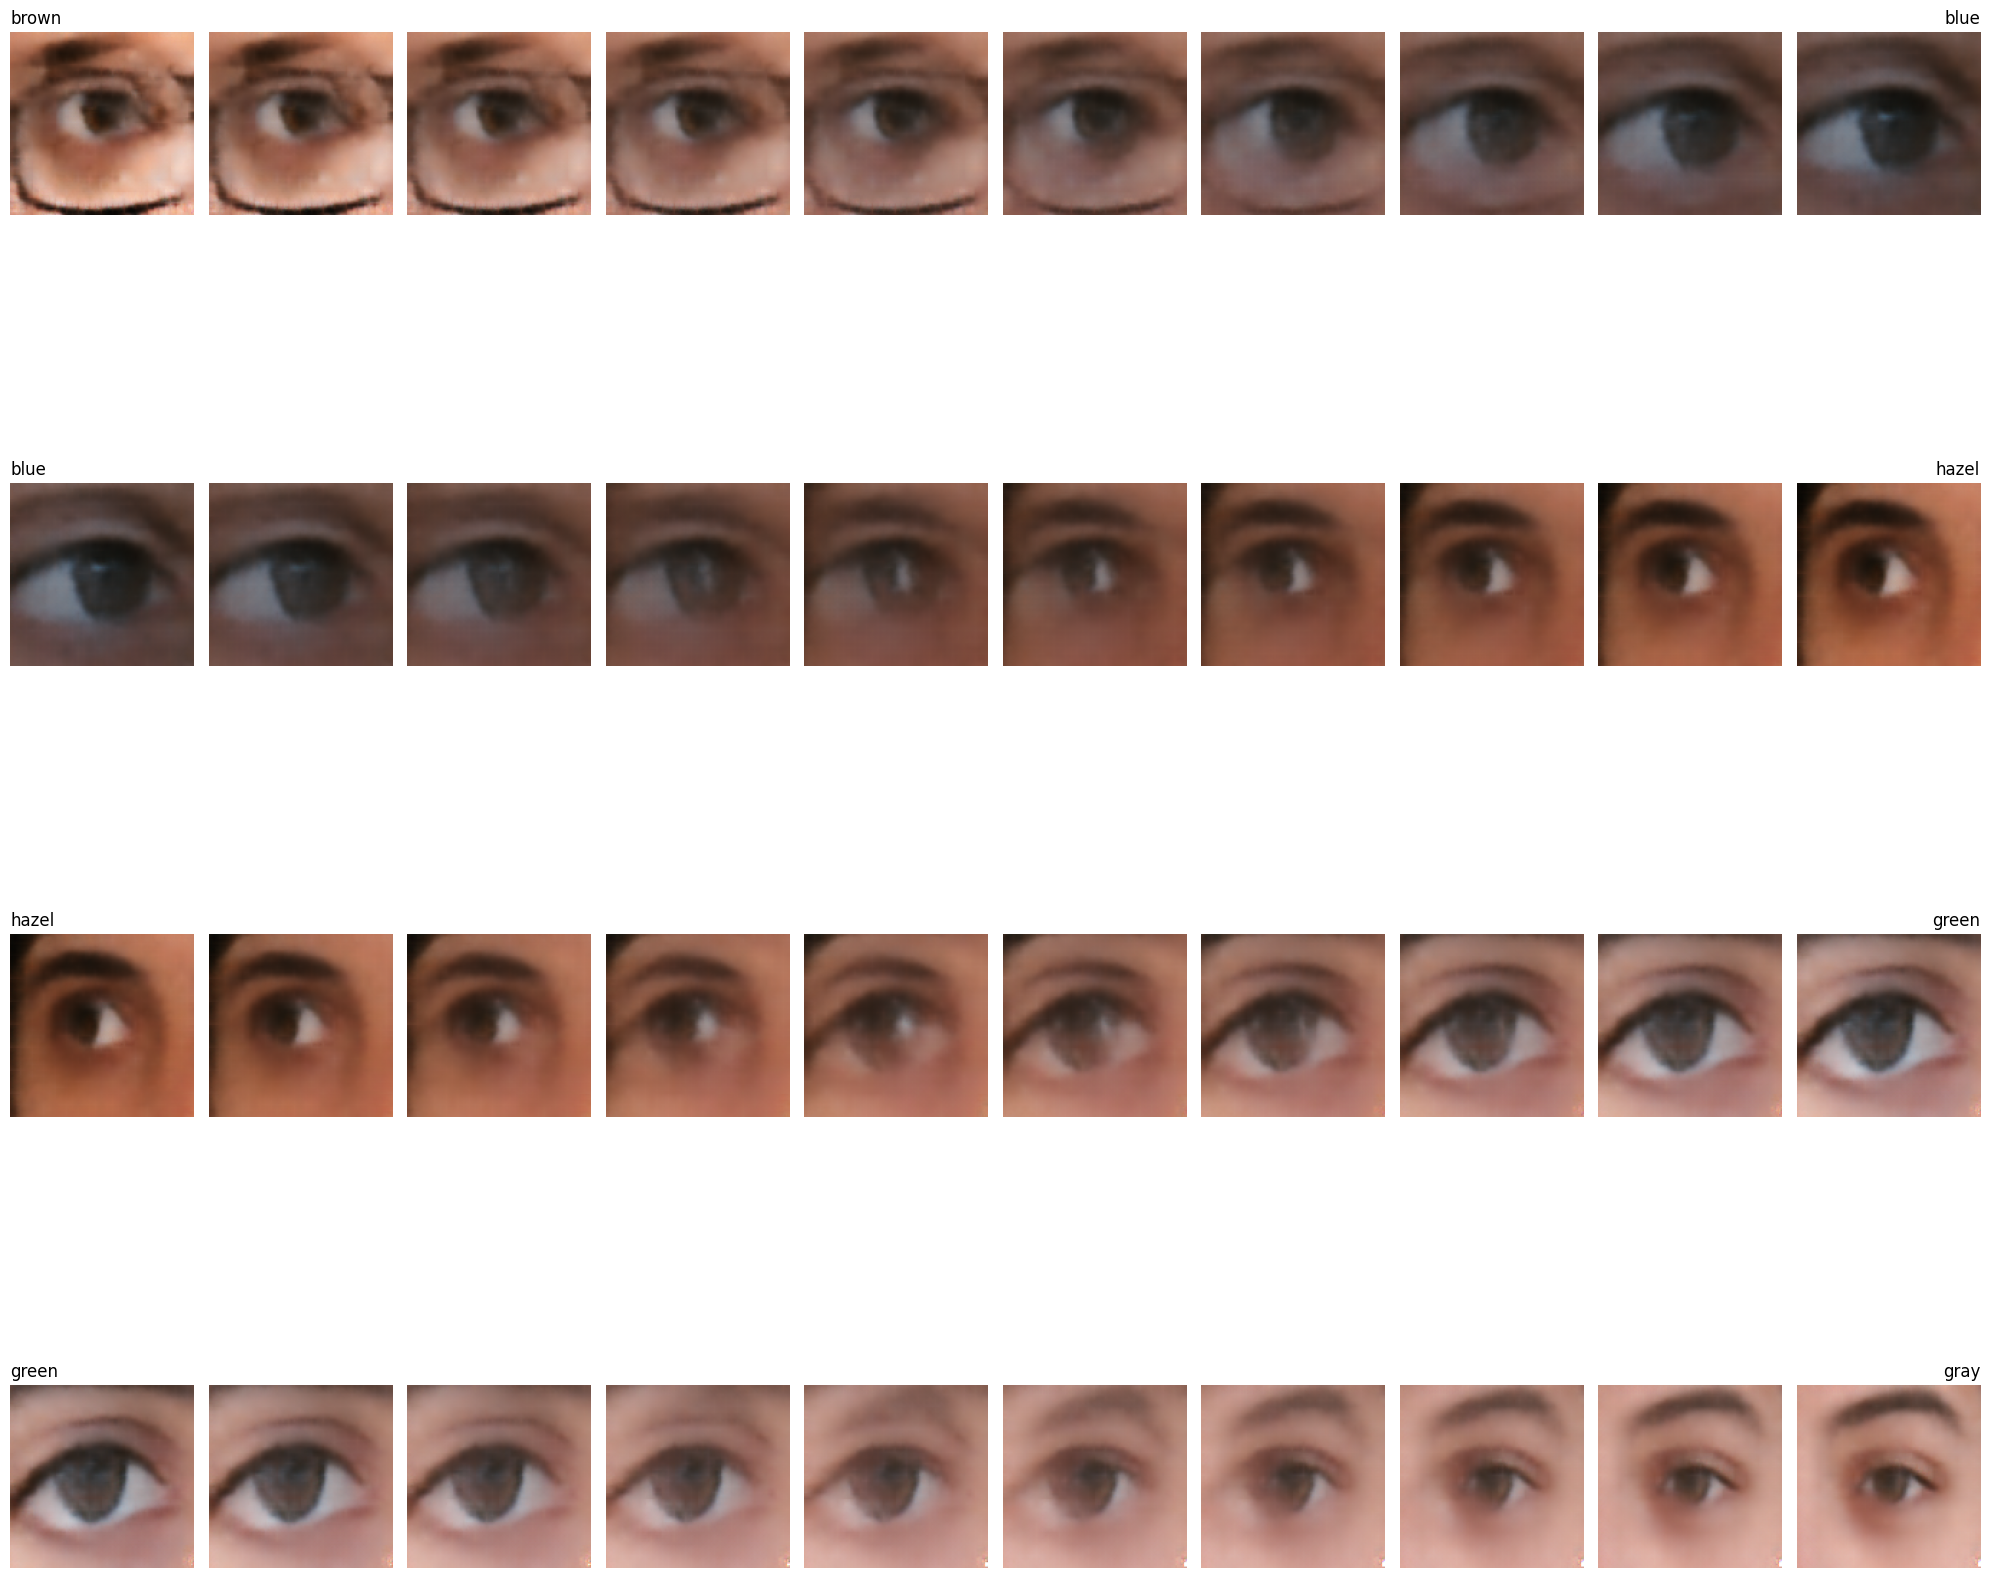


Finding best representative images for each color class...

Experimenting with hue...

Calculating reconstruction metrics...
70/70 [==============================] - 17s 237ms/step

Reconstruction Metrics:
MSE: 0.0029
RMSE: 0.0543
MAE: 0.0363
PSNR: 25.3092

Generating t-SNE visualization...


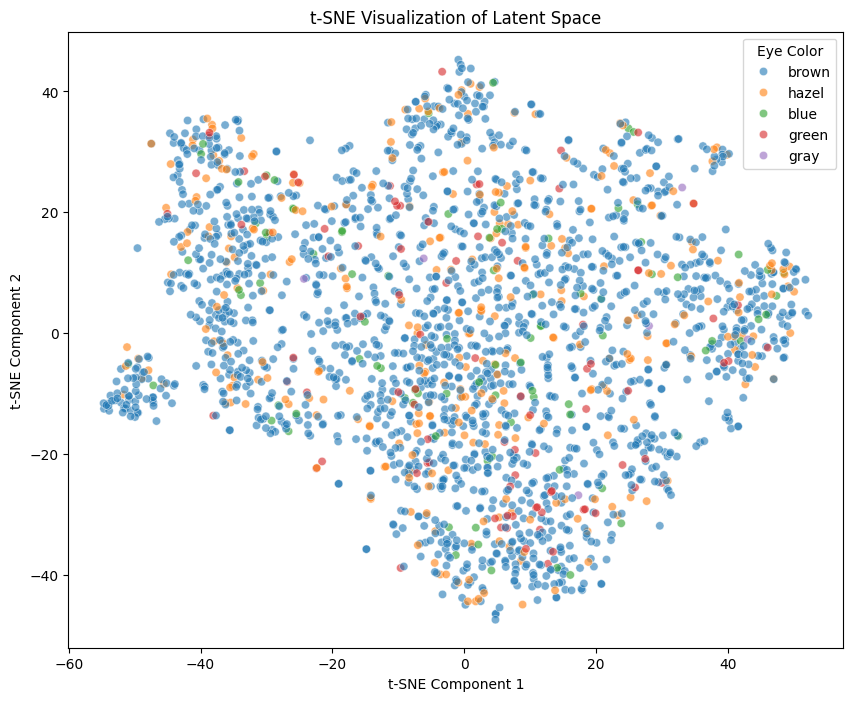


Generating additional visualizations...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


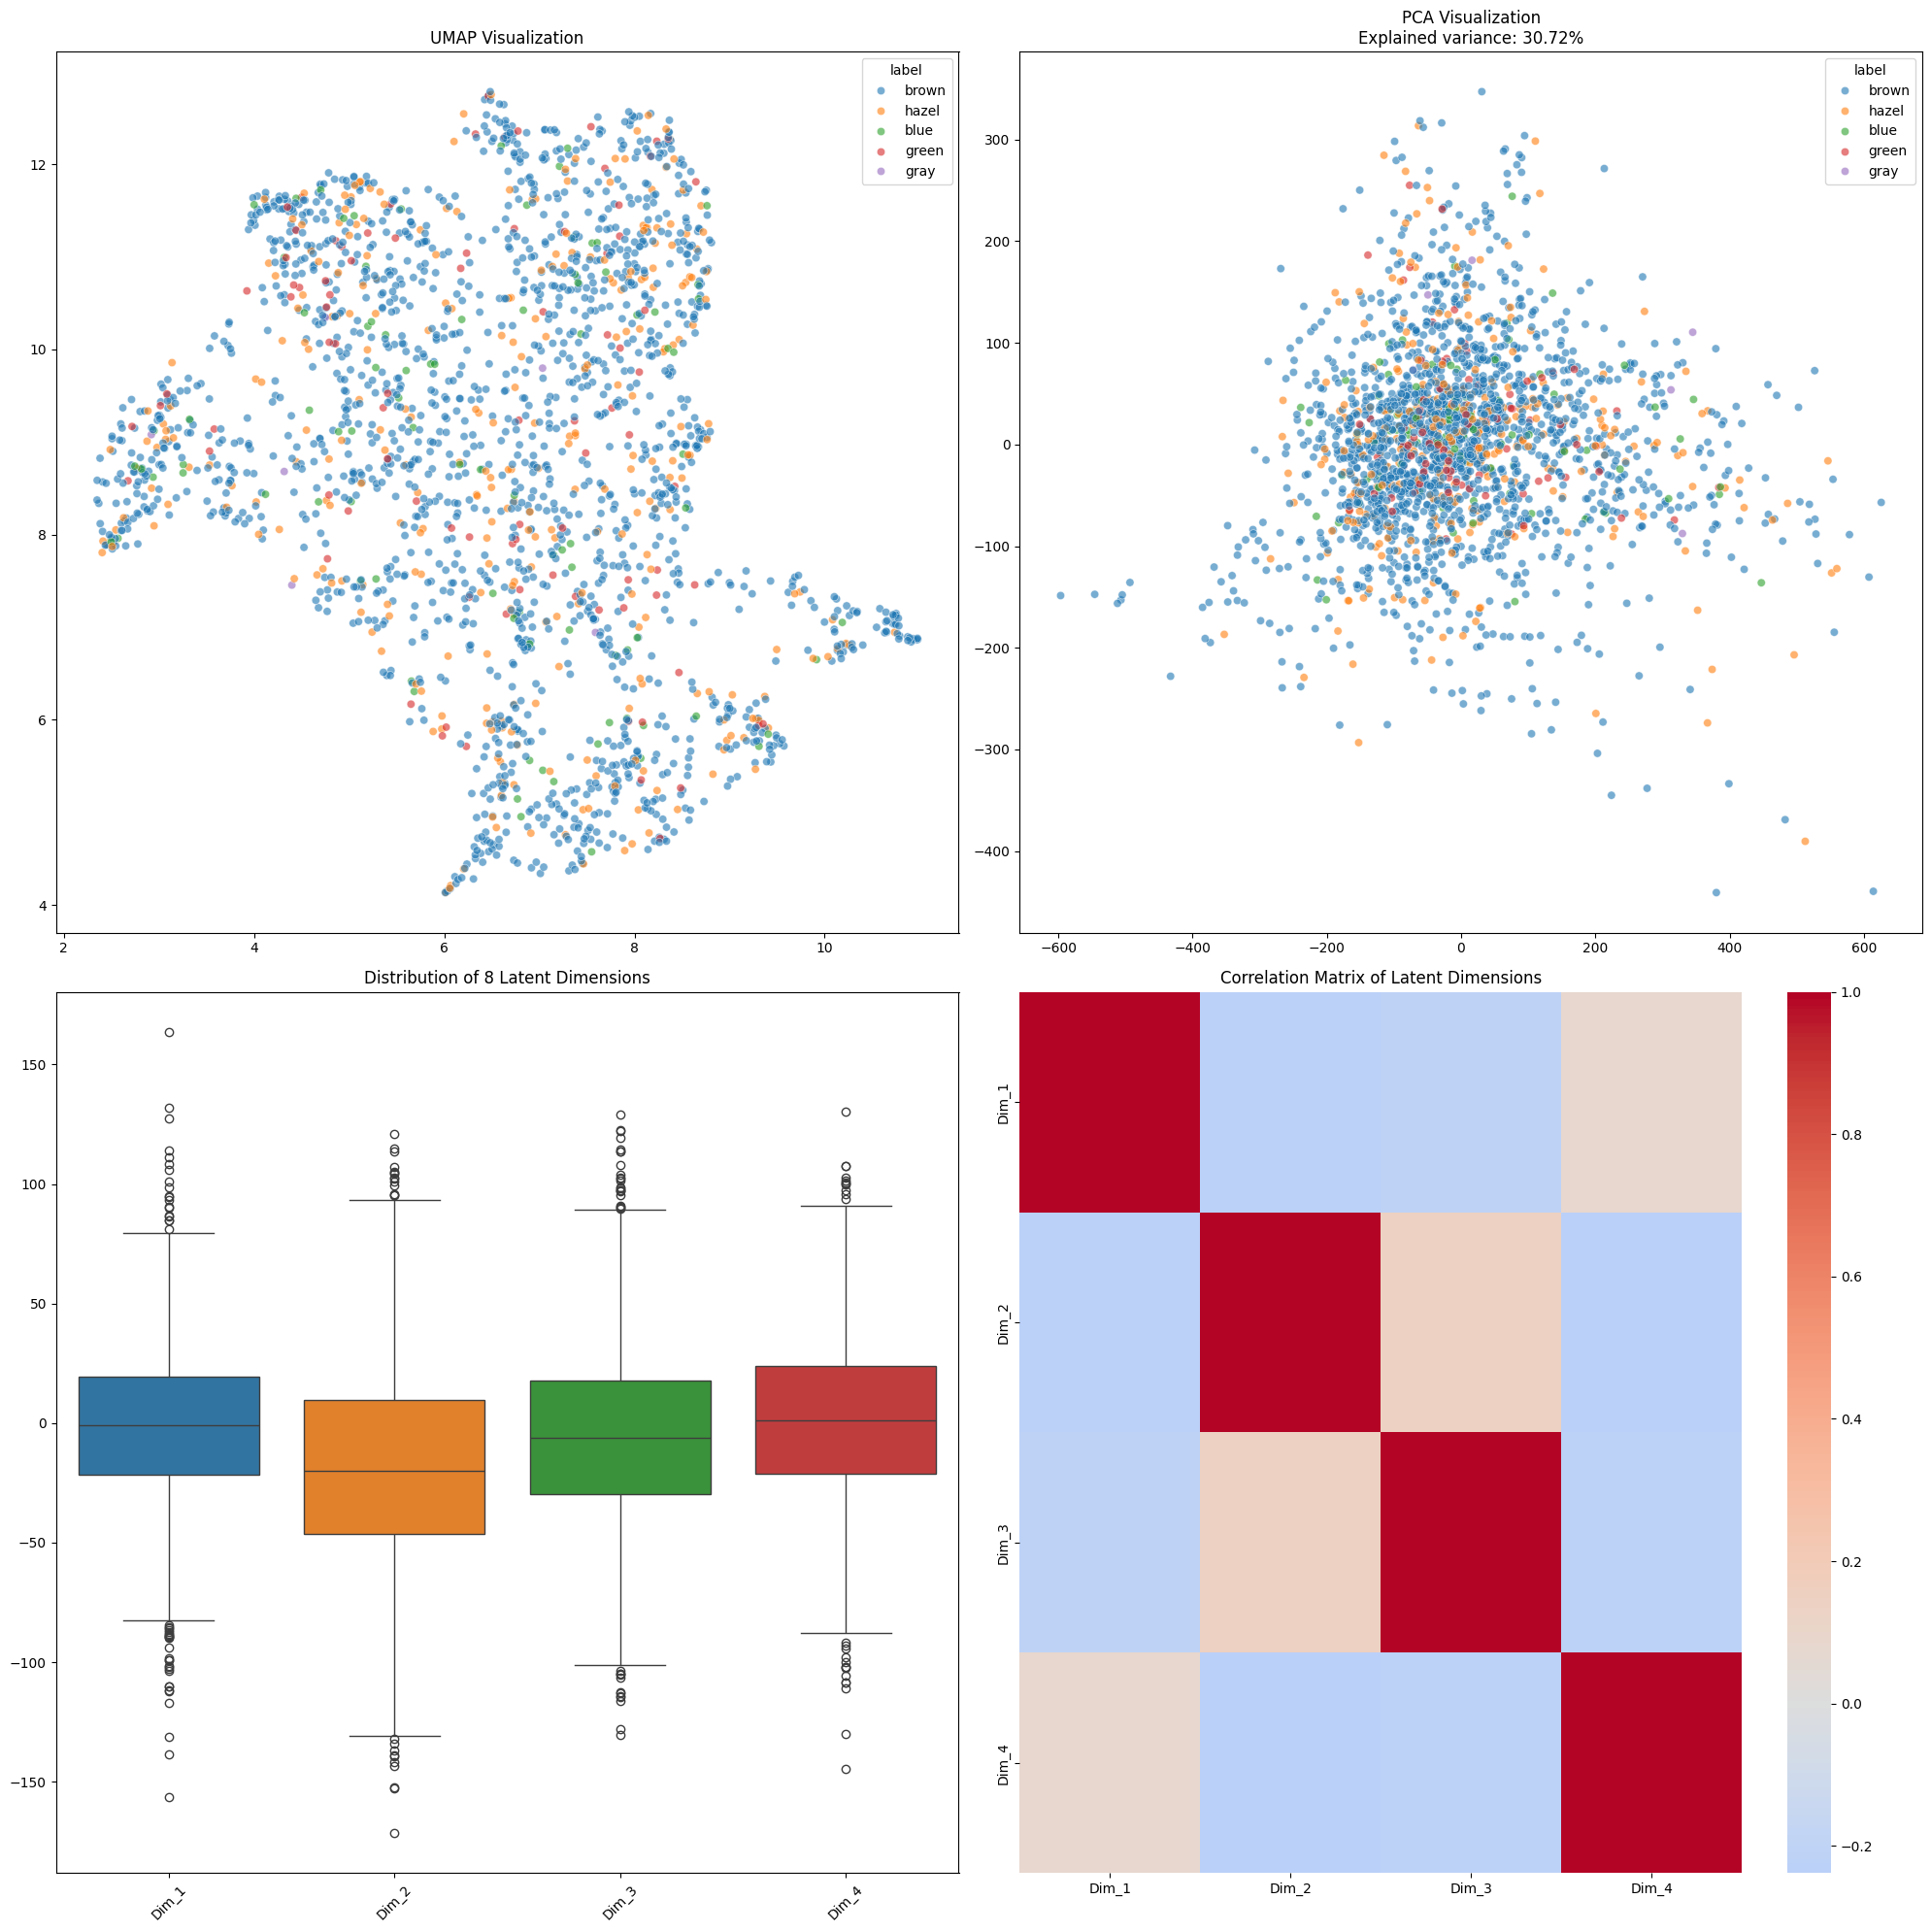

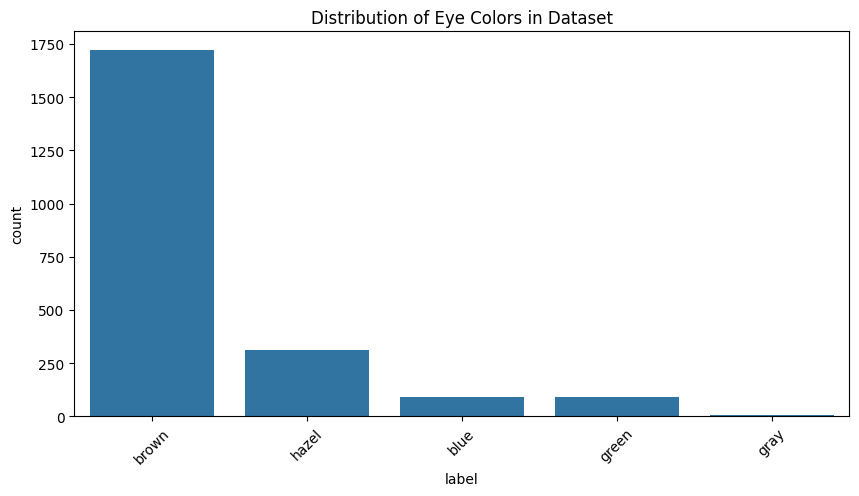

In [61]:
# USE THOS

if __name__ == "__main__":
    # Load the labels
    labels_df = pd.read_csv('/content/drive/MyDrive/ML final project/datasets/test_labels.csv')

    color_mapping = {
        'brown': [165, 42, 42],  # Example RGB for brown
        'blue': [0, 0, 255],    # Example RGB for blue
        'hazel': [184, 134, 11],  # Example RGB for hazel
        'green': [0, 128, 0]   # Example RGB for green
    }

    print("Reconstructing sample images...")
    reconstruct_images(test_latent_vectors)

    print("\nInterpolating between different eye colors...")
    #interpolate_color_sequence(decoder, latent_vectors, labels_df)
    randomer_interpolater(decoder, test_latent_vectors, test_labels_df)

    #interpolated_images, true_labels = interpolate_color_sequence(decoder, latent_vectors, labels_df)
    #interpolation_accuracy = calculate_interpolation_accuracy(interpolated_images, true_labels, color_mapping)

    print("\nFinding best representative images for each color class...")
    #find_best_representative_images(image_data, labels_df)

    print("\nExperimenting with hue...")
    #interpolate_and_apply_color_from_classes(find_best_representative_images(image_data, labels_df), image_data, labels_df)

    # Calculate reconstruction metrics
    print("\nCalculating reconstruction metrics...")
    reconstructed_images = decoder.predict(test_latent_vectors)
    metrics = calculate_reconstruction_metrics(test_image_data, reconstructed_images)

    print("\nReconstruction Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    # Visualize latent space using t-SNE
    print("\nGenerating t-SNE visualization...")
    plot_tsne_visualization(test_latent_vectors, test_labels_df)

    # Add to your main section:
    print("\nGenerating additional visualizations...")
    plot_multiple_visualizations(test_latent_vectors, test_labels_df)

# Plots and reconstruction metrics for latent dimension of 64:


## Reconstruction Metrics:
- MSE (Mean Squared Error): 0.0029 - Very low, indicating good reconstruction accuracy
- RMSE (Root Mean Squared Error): 0.0543 - Square root of MSE, also showing good performance
- MAE (Mean Absolute Error): 0.0363 - Low average absolute difference between original and reconstructed images
- PSNR (Peak Signal-to-Noise Ratio): 25.3092 - A decent PSNR value; higher values indicate better quality reconstruction (typical good values are between 20-50)


## T-SNE Visualization of Latent Space:
- Shows a 2D projection of the 64-dimensional latent space using t-SNE
- Points are color-coded by eye color (brown, hazel, blue, green, gray)
- The visualization shows:
- Some clustering of similar eye colors, but with significant overlap
- Brown eyes (blue dots) dominate the space, reflecting the class imbalance we saw earlier

## UMAP Visualization:
- Shows a non-linear dimensionality reduction of the same data
- Creates more distinct clusters and preserves local structure better than PCA
- Points are more tightly grouped together (range roughly 2-12 on y-axis, 2-10 on x-axis)
- Uses the same color coding for eye colors
- Shows some natural clustering of similar eye colors, though there is still significant overlap
- The key differences between these visualizations demonstrate the different approaches to dimensionality reduction:
- PCA is a linear technique that maximizes variance along principal components, resulting in a more spread-out visualization
- UMAP is non-linear and better preserves local relationships, resulting in more clustered data points

## PCA Visualization:
- Shows the data projected onto its first two principal components
- Explains 30.72% of the total variance in the data
- Shows a more scattered distribution with less distinct clustering
- Points are spread over a wider range (-600 to 600 on x-axis, -400 to 300 on y-axis)
- Color coding represents different eye colors (brown, hazel, blue, green, gray)

## Distribution of First 10 Latent Dimensions :
- Shows box plots for the first 10 dimensions of the latent space
- Each box plot shows:
- Median (horizontal line in box)
- Interquartile range (box)
- Whiskers extending to the most extreme non-outlier points
- Individual outlier points (circles)
- The distributions vary across dimensions but generally:
- Center around 0
- Have similar ranges (roughly -100 to 150)
- Show considerable outliers in most dimensions
- This suggests the autoencoder is using the full range of each dimension to encode different features

## Correlation Matrix of Latent Dimensions (bottom plot):
- Shows the pairwise correlations between the first 10 latent dimensions
- Color scale:
- Red indicates positive correlation
- Blue indicates negative correlation
- Intensity represents correlation strength
- The diagonal is bright red (correlation = 1.0) as expected (self-correlation)
- Most off-diagonal elements show weak correlations (light colors)
- This suggests the latent dimensions are relatively independent of each other, which is desirable as it means the autoencoder has learned to encode different features in different dimensions without much redundancy

## Distribution of classes
Brown eyes are heavily dominant with approximately 1,700 samples
Hazel eyes are the second most common with around 300 samples
Blue eyes have roughly 100 samples
Green eyes have about 75 samples
Gray eyes appear to have the fewest samples, with less than 50
This imbalance in the dataset is important to note because:
It could bias the model towards better recognition of brown eyes
It might lead to poorer performance on underrepresented colors like gray
It reflects real-world distributions of eye colors (brown is indeed the most common globally)

# Plots and Reconstruction Metrics For Latent Diminsion 32:

## Reconstruction Metrics Comparison:
- MSE: Increased from 0.0029 to 0.0040 (worse)
- RMSE: Increased from 0.0543 to 0.0629 (worse)
- MAE: Increased from 0.0363 to 0.0430 (worse)
- PSNR: Decreased from 25.3092 to 24.0301 (worse)
- These metrics indicate that reducing the latent dimension from 64 to 32 resulted in slightly worse reconstruction quality, which is expected as we're compressing the information into fewer dimensions.
## Visualization Comparisons:
## t-SNE Plots:
- Both show similar overall structure
- The 32-dim version shows:
- Slightly more distinct clusters
- More defined separation between some groups
- Similar overlap patterns between eye colors
- Maintains the dominance of brown eyes in the distribution
## UMAP Visualizations:
- Both maintain similar overall structure
- 32-dim version shows:
- More compact clustering
- Similar pattern of color distribution
- Slightly different scale (2-12 vs 3-9 on y-axis)
## PCA Visualizations:
- Explained variance decreased from 30.72% to 26.79%
- Similar overall distribution pattern
- Slightly more concentrated central cluster in the 32-dim version
- Distribution & Correlation Plots:
- Box plots show similar distributions across dimensions
- Correlation matrices show:
- Similar patterns of independence between dimensions
- Slightly stronger correlations in some dimensions for the 32-dim version
## Distribution Plot:
- Shows box plots for each dimension (Dim_1 to Dim_10)
- Most dimensions are centered around 0
- Notable variations in spread:
- Dim_6 shows the largest spread and many outliers (reaching up to 400)
- Dim_9 has a more compact distribution with negative skew
- Most other dimensions have similar spreads (-100 to 200 range)
- Outliers are present in all dimensions (dots beyond whiskers)
- The medians (horizontal lines in boxes) vary across dimensions but stay relatively close to 0
## Correlation Matrix:
- Shows pairwise correlations between dimensions
- Diagonal is bright red (1.0) as expected (self-correlation)
- Most off-diagonal elements show weak correlations (light colors)
- Some notable patterns:
- Dim_1 and Dim_3 show slight positive correlation (light pink)
- Dim_1 and Dim_5 show slight negative correlation (light blue)
- Dim_2 and Dim_7 show weak positive correlation
- Most other pairs show very weak or no correlation

# Plots and Reconstruction Metrics For Latent Diminsion 16:

## Reconstruction metrics
- MSE: 0.0029 → 0.0040 → 0.0053 (getting worse)
- RMSE: 0.0543 → 0.0629 → 0.0725 (getting worse)
- MAE: 0.0363 → 0.0430 → 0.0503 (getting worse)
- PSNR: 25.3092 → 24.0301 → 22.7904 (getting worse)
- This trend shows that reconstruction quality is decreasing as we reduce the - - latent space dimensions or make other model changes.


## t-SNE Visualization Comparison:
- Overall Structure:
- Similar butterfly/spread pattern maintained across all versions
- Current plot shows slightly more diffuse clustering
- Maintains roughly the same range (-40 to 40 on both axes)
- Color Distribution:
- Brown eyes (blue dots) still dominate the space
- Similar mixing patterns between different eye colors
- Perhaps slightly less defined clusters compared to previous versions
- Clustering:
- Less distinct grouping compared to previous versions
- More uniform spread of points
- Smoother transitions between different regions

## UMAP Visualization (Top Left):
- Scale has changed (now 2-11 on y-axis, compared to previous 3-9)
- Shows clearer, more defined clusters
- Better separation between different regions
- Similar pattern of brown eye dominance but with more distinct grouping
- More structured layout compared to previous versions


## PCA Visualization (Top Right):
- Explained variance is 28.90% (up from 26.79% in 32-dim version)
- More spread out distribution (-400 to 300 on both axes)
- Shows clearer radial pattern from center
- Better defined clusters while maintaining natural overlap between colors
- More balanced distribution of points


## Distribution of First 10 Latent Dimensions (Bottom Left):
- More consistent ranges across dimensions (mostly -200 to 300)
- Dim_6 shows larger spread but less extreme than previous version
- More balanced outlier distribution
- Medians closer to zero across dimensions
- More consistent box sizes indicating more uniform feature encoding


## Correlation Matrix (Bottom Right):
- Stronger correlations visible between some dimensions (brighter reds/blues)
- More structured correlation patterns
- Notable correlations:
- Dim_1 and Dim_2 show stronger positive correlation
- Several negative correlations (blue) are more pronounced
- Overall more organized correlation structure
- Overall Improvements:
- Better organization of latent space (clearer UMAP clusters)
- Higher explained variance in PCA
- More balanced dimension distributions
- More structured correlations between dimensions

# Plots and Reconstruction Metrics For Latent Diminsion 8:

## Reconstruction Metrics Comparison:
- 64-dim → 32-dim → Previous → 8-dim
- MSE: 0.0029 → 0.0040 → 0.0053 → 0.0076 (continuing to increase)
- RMSE: 0.0543 → 0.0629 → 0.0725 → 0.0875 (continuing to increase)
- MAE: 0.0363 → 0.0430 → 0.0503 → 0.0629 (continuing to increase)
- PSNR: 25.3092 → 24.0301 → 22.7904 → 21.1643 (continuing to decrease)

- This trend clearly shows that reconstruction quality continues to degrade as we reduce the latent dimensions, which is expected due to the increased compression.


## t-SNE Visualization Comparison:

- Similar butterfly/spread pattern maintained
- Slightly larger range (-40 to 60 on y-axis, compared to previous -40 to 40)
- More pronounced clusters at the edges
- Clearer separation between some groups
- The higher error metrics confirm we're losing some reconstruction fidelity with 8 dimensions
- However, the t-SNE plot suggests the 8-dimensional space is still capturing meaningful features and relationships
- The more distinct clustering might indicate the model is focusing on more fundamental features due to the dimensional constraint
- The trade-off between compression and quality is evident but might be acceptable depending on your use case
- This version with 8 dimensions shows that while we're sacrificing some reconstruction quality, the model is still maintaining meaningful feature organization in the latent space.

## UMAP Visualization (Top Left):
- Scale now 0-10 on y-axis (compared to 2-11 previously)
- Maintains similar overall structure but with:
- More compact clustering
- Clearer separation between regions
- Better defined local neighborhoods
- Despite only 8 dimensions, shows good preservation of data relationships
- Color distribution remains consistent with previous versions


## PCA Visualization (Top Right):
- Explained variance increased significantly to 40.61% (up from 28.90% in previous version)
- This is a notable improvement, suggesting the 8 dimensions are capturing the most important variations more efficiently
- Range remains similar (-400 to 400 on both axes)
- More concentrated central cluster with clear radial distribution
- Better defined structure compared to higher dimensional versions
- Distribution of 8 Latent Dimensions (Bottom Left):
- Now showing only 8 dimensions (correctly adjusted for the model)
- More varied distributions across dimensions
- Notable features:
- Dim_6 shows largest spread and most outliers
- Dim_8 shows strong negative skew
- More extreme outliers in several dimensions
- Medians still centered around 0


## Distribution of 8 Latent Dimensions (Bottom Left):
- More varied distributions across dimensions
- Dim_6 shows largest spread and most outliers
- Dim_8 shows strong negative skew
- More extreme outliers in several dimensions
- Medians still centered around 0


## Correlation Matrix (Bottom Right):
- Stronger correlations visible
- Notable positive correlation between Dim_1 and Dim_2
- Strong negative correlations (blue) between several dimensions
- More pronounced correlation patterns overall
- Suggests dimensions are working together more closely to encode features

# Result of interpolate_color_sequence(decoder, latent_vectors, labels_df)
# NOTE: These results were also using the filtered iris dataset. If you want to reproduce this, you must load the proper dataset.

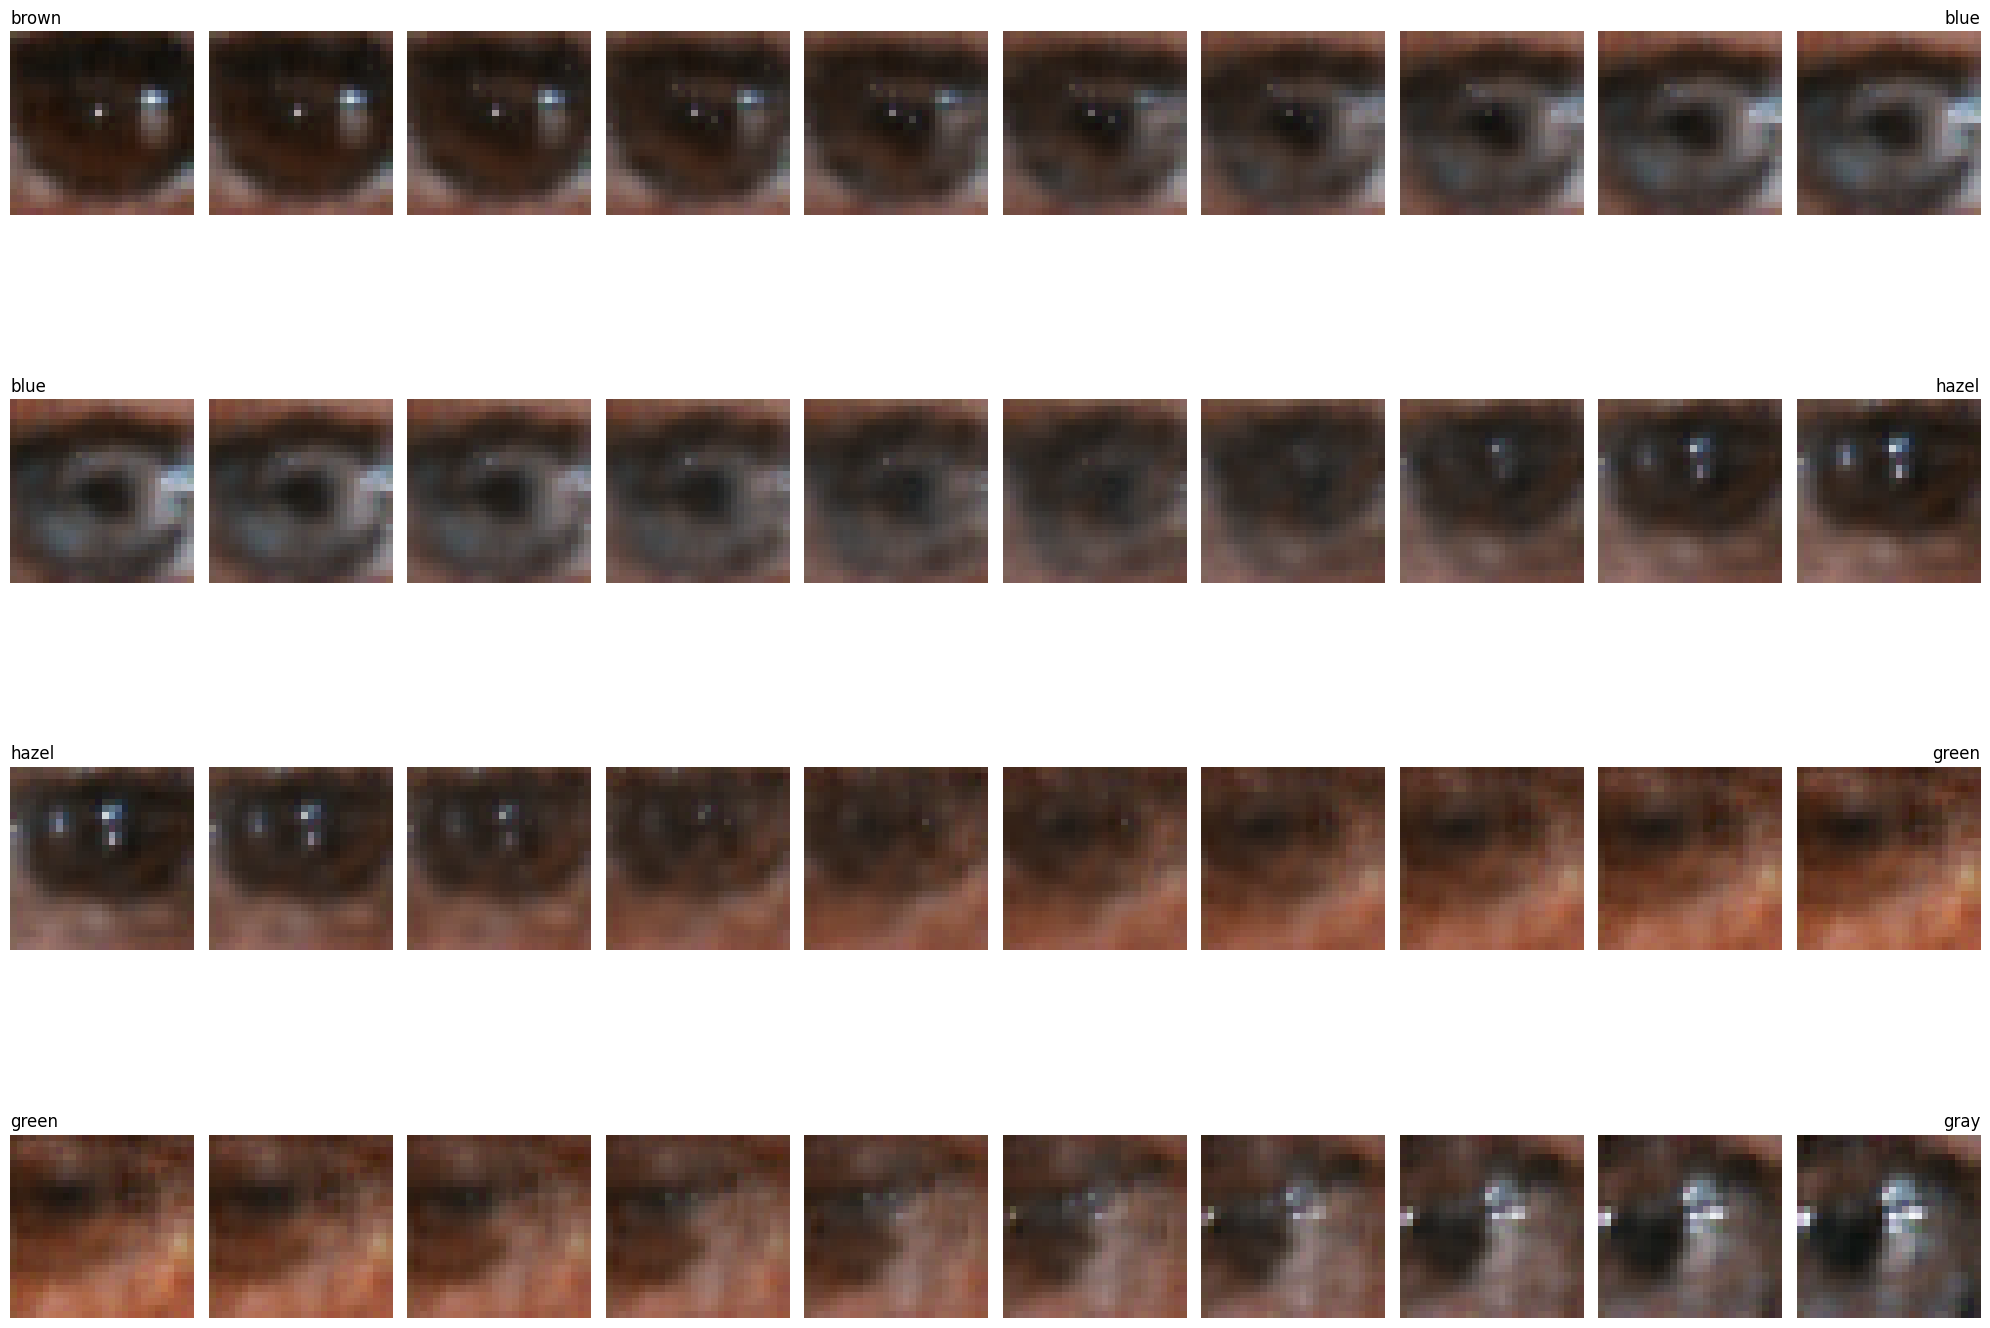

In [62]:
def interpolate_two_images(latent_vector1, latent_vector2, num_steps=10):
    alphas = np.linspace(0, 1, num_steps)
    interpolated_vectors = []

    for alpha in alphas:
        interpolated_vector = (1 - alpha) * latent_vector1 + alpha * latent_vector2
        interpolated_vectors.append(interpolated_vector)

    # Reshape the interpolated_vectors to (num_steps, 64)
    interpolated_vectors = np.array(interpolated_vectors).reshape(num_steps, latent_vector1.shape[-1]) # Reshape to match decoder input
    interpolated_images = decoder.predict(interpolated_vectors)

    # Display interpolation results
    plt.figure(figsize=(15, 3))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i + 1)
        plt.imshow(interpolated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# TESTING GROUP MEMBER EYES

1/1 [==============================] - 0s 158ms/step


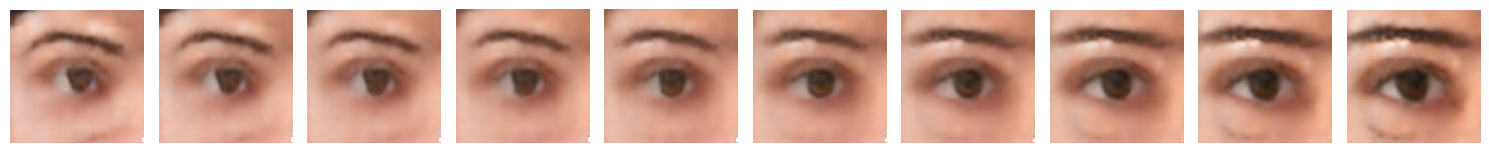

In [63]:
latent_vector1 = encoder.predict(np.expand_dims(image1_preprocessed, axis=0))
latent_vector2 = encoder.predict(np.expand_dims(image2_preprocessed, axis=0))
latent_vector3 = encoder.predict(np.expand_dims(image3_preprocessed, axis=0))


interpolate_two_images(latent_vector1, latent_vector2, num_steps=10)

# GRADIO TESTING

In [26]:
import gradio as gr
import imageio

In [66]:
def create_interpolation(img1, img2):
    """Handle the Gradio interface and create interpolation"""
    try:
        # Directly normalize the input images without color space conversion
        img1_preprocessed = np.array(img1).astype(np.float32) / 255.0
        img2_preprocessed = np.array(img2).astype(np.float32) / 255.0

        # Resize if needed
        if img1_preprocessed.shape[:2] != (IMG_SIZE, IMG_SIZE):
            img1_preprocessed = cv2.resize(img1_preprocessed, (IMG_SIZE, IMG_SIZE))
        if img2_preprocessed.shape[:2] != (IMG_SIZE, IMG_SIZE):
            img2_preprocessed = cv2.resize(img2_preprocessed, (IMG_SIZE, IMG_SIZE))

        # Get latent vectors
        latent1 = encoder.predict(np.expand_dims(img1_preprocessed, axis=0))
        latent2 = encoder.predict(np.expand_dims(img2_preprocessed, axis=0))

        # Create interpolation vectors
        num_steps = 10
        alphas = np.linspace(0, 1, num_steps)
        interpolated_vectors = [(1 - alpha) * latent1[0] + alpha * latent2[0] for alpha in alphas]

        # Generate images from interpolated vectors
        interpolated_images = decoder.predict(np.array(interpolated_vectors))

        # Post-process images
        interpolated_images = np.clip(interpolated_images * 255, 0, 255).astype(np.uint8)

        # Create GIF with forward and backward interpolation for smooth loop
        frames = list(interpolated_images) + list(interpolated_images[::-1])

        # Create GIF that loops 10 times
        output_path = "interpolation.gif"
        imageio.mimsave(output_path, frames, duration=200, loop=10)

        return output_path

    except Exception as e:
        print(f"Error: {str(e)}")
        raise gr.Error(str(e))


# Create two tabs: one for file upload and one for webcam
with gr.Blocks(css=".gradio-container {height: 1200px}") as demo:
    gr.Markdown("# Eye Color Interpolation")
    gr.Markdown("Upload two eye images or use webcam to capture images and see the interpolation between them.")

    with gr.Tab("Upload Images"):
        with gr.Row():
            image1_upload = gr.Image(type="numpy", label="First Image")
            image2_upload = gr.Image(type="numpy", label="Second Image")
        upload_button = gr.Button("Create Interpolation")
        output_upload = gr.Image(type="filepath", label="Interpolation Result")
        upload_button.click(
            create_interpolation,
            inputs=[image1_upload, image2_upload],
            outputs=output_upload
        )

    with gr.Tab("Webcam"):
        with gr.Row():
            image1_webcam = gr.Image(type="numpy", label="First Image", sources="webcam")
            image2_webcam = gr.Image(type="numpy", label="Second Image", sources="webcam")
        webcam_button = gr.Button("Create Interpolation")
        output_webcam = gr.Image(type="filepath", label="Interpolation Result")
        webcam_button.click(
            create_interpolation,
            inputs=[image1_webcam, image2_webcam],
            outputs=output_webcam
        )

# Launch the interface
demo.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0cbce9aea1c21fc37e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 148ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0cbce9aea1c21fc37e.gradio.live
